# Implementing a CGAN for the MNIST data set to generate synthetic data
### Import necessary modules and packages

In [38]:
import os
while os.path.basename(os.getcwd()) != 'CSDGAN':
    os.chdir('..')
from CSDGAN.classes.image.ImageCGAN import ImageCGAN
import configs.MNIST as cfg
from utils.data_loading import *
from CSDGAN.classes.image.ImageDataset import ImageDataset, GeneratedImageDataset
from utils.image_utils import img_dataset_preprocessor, show_real_grid, augment
from torch.utils import data
import os
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

This notebook will look fairly different from the others. As I've gotten more familiar with designing and implementing GANs, the code is significantly more modular and less monolithic. The CGAN class now consists of three neural networks: netG, netD, and netE (Evaluator). Feel free to check out the model files in the models/MNIST directory for more detail.

### Set random seed for reproducibility

In [2]:
print("Random Seed: ", cfg.MANUAL_SEED)
random.seed(cfg.MANUAL_SEED)
torch.manual_seed(cfg.MANUAL_SEED)

Random Seed:  999


### Inspect config file
I have also implemented a config/MNIST.py file for all relevant user inputs for training the model. I recommend checking out this file and playing around with the inputs in order to experiment! I'm curious what results you may find. I will print out the current config setup below so that you have a good idea of the out-of-the-box parameters:

In [3]:
print("Experiment Name:", cfg.EXPERIMENT_NAME)  #  Where output files will be saved
print("Manual Seed:", cfg.MANUAL_SEED)  # This is above

print("\nEvaluation Parameters:")
print("Train/Test/Validation Splits:", cfg.SPLITS)  # Must sum to 1.0
print("Total Number of Epochs:", cfg.NUM_EPOCHS)
print("Printing Frequency:", cfg.PRINT_FREQ)  # How often to print results to the console (in epochs)
print("Evaluation Frequency:", cfg.EVAL_FREQ)  # How often to train the evaluator on generated data (in epochs)

print("\nTraining Parameters:")  # Whether to shuffle the data for training, and number of cpu workers for concurrency
for key, value in cfg.TRAINING_PARAMS.items():
    print(key + ": " + str(value))

    print("\nCGAN Class Initialization Parameters:")  # See the config file for more detail behind what these choices represent
for key, value in cfg.CGAN_INIT_PARAMS.items():
    print(key + ": " + str(value))

Experiment Name: MNIST_Notebook_Example2
Manual Seed: 999

Evaluation Parameters:
Train/Test/Validation Splits: [0.15, 0.05, 0.8]
Total Number of Epochs: 400
Printing Frequency: 5
Evaluation Frequency: 50

Training Parameters:
batch_size: 128

CGAN Class Initialization Parameters:
shuffle: True

CGAN Class Initialization Parameters:
num_workers: 6

CGAN Class Initialization Parameters:
sched_netG: 2
label_noise: 0.25
label_noise_linear_anneal: True
discrim_noise: 0.25
discrim_noise_linear_anneal: False
nc: 10
nz: 64
num_channels: 1
netG_nf: 128
netD_nf: 128
netG_lr: 0.0002
netD_lr: 0.0002
netE_lr: 0.0002
netG_beta1: 0.5
netG_beta2: 0.999
netD_beta1: 0.5
netD_beta2: 0.999
netE_beta1: 0.5
netE_beta2: 0.999
netG_wd: 0
netD_wd: 0
netE_wd: 0
fake_data_set_size: 50000
fake_bs: 128
eval_num_epochs: 40
early_stopping_patience: 3


Definitely the most interesting of these to mess around with are the following:
1. Train/Test/Validation Splits - Using more/less data for training could yield some valuable insights about the efficacy of this approach.
2. Number of Epochs - Training for longer could improve the model, or could result in a form of GAN failure.
3. Label Noise/Discriminator Noise and whether to linearly anneal - I found that without adding noise the discriminator's training process, it completely dominated the generator. Adding in noise resulted in significant gains for the model as shown in the evaluator score. My selection here is by no means optimal, feel free to play around with a few different choices! If you want to really go above and beyond, try messing wtih the source code to implement a different form of annealing, such as logarithmic.
4. Size of noise vector (nz) - Using more or less noise could impact the expressivity of the generator model as well as how much it pays attention to class labels.
5. Number of features for netG and netD - This could also impact the expressivity of both generator and discriminator models.
6. Adam Optimizer parameters (learning rate, beta1 and beta2) - These are simply copied from the original GAN paper. They seem to work well, but perhaps could be improved upon!
7. Weight decay - I didn't experiment much with this, but perhaps it could affect the performance.
8. The remainder of the parameters are involved with the evaluator training. Messing with these shouldn't have too much of an impact on performance, but could lead to some interesting differences in reporting.
9. netG Schedule - How many steps to train the generator for each step of training the discriminator. Note that the discriminator is effectively trained on twice as many data points as the generator when this is set equal to 1 since it is trained on a batch of real data as well as a batch of fake data.

### What exactly is this label noise/discriminator noise?

##### Label noise: 
With probability label_noise, the labels for the discriminator's training (real or fake) are randomly flipped. For example, when training the discriminator, we traditionally feed it an entire batch of real images (labeled real), followed by an entire batch of fake images (labeled fake), and then update it based on how well it performed. In this case, when we feed it an entire batch of real images, we flip a percent of the labels to fake, so that we are feeding the discriminator some incorrect information (we do this for the fake images as well, labeling them as real). This results in inhibiting the discriminator's training process and tries to prevent the discriminator from learning simple tricks to detect whether an image is real or fake. For example, let's say the generator always added a few pixels to the bottom left-hand side of the screen. The discriminator might pick up on this and only focus on those few pixels in order to classify images as real or fake. It might be difficult for the generator to figure out to change just those few pixels. As an aside on choosing values for this parameter, it wouldn't make much sense to raise this value above 0.5, since at that point it would essentially be training the discriminator to be incorrect.

##### Discriminator noise:
This value is the standard deviation of normally distributed noise (with mean zero) added to the discriminator's input image each time it evaluates real or fake images. This is a general trick employed in deep learning to improve robustness of models to noise, but also further prevents the discriminator from getting too good at discriminating reals from fakes based on some trivial pixels.

### Directory for outputs

In [4]:
exp_path = os.path.join("experiments", cfg.EXPERIMENT_NAME)  # Path to model training diagnostic visualization
print("Files for this experiment will end up here:", exp_path)

Files for this experiment will end up here: experiments/MNIST_Notebook_Example2


### Import data and split

In [5]:
mnist = load_processed_dataset('MNIST')
x_comb, y_comb = torch.cat((mnist[0][0], mnist[1][0]), 0).numpy(), torch.cat((mnist[0][1], mnist[1][1]), 0).numpy()
x_train, y_train, x_val, y_val, x_test, y_test, le, ohe = img_dataset_preprocessor(x=x_comb, y=y_comb, splits=cfg.SPLITS, seed=cfg.MANUAL_SEED)

/home/aj/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:414: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


### Print an example image

Printing an image of a 3:


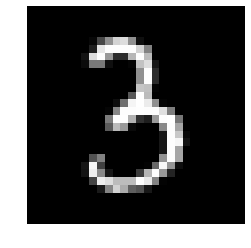

In [6]:
%matplotlib inline
print("Printing an image of a", str(np.argmax(y_train[5].numpy()))+":")
plt.imshow(x_train[5], cmap='gray')
plt.axis("off")
plt.show()

### Automatically set these parameters

In [7]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")  # GPU if exists, else CPU
x_dim = (x_train.shape[1], x_train.shape[2])  # Dimensions of input images

print("Device:", device)
print("Image dimensions:", x_dim)

Device: cuda:0
Image dimensions: (28, 28)


### Define and instantiate data set and generator
I'm using Pytorch's built-in datasets and generator classes. Pytorch allows you to write custom Dataset classes quickly and easily in order to make this process as painless as possible. I recommend checking out the code and using these yourselves! The minimum requirements are that you need to implement a __len__ and __getitem__ function, so that all of the other juicy Pytorch functionality can work appropriately.

Here we set up a generator for each of our train/val/test splits:

In [8]:
train_dataset = ImageDataset(x=x_train, y=y_train)
train_gen = data.DataLoader(train_dataset, **cfg.TRAINING_PARAMS)

val_dataset = ImageDataset(x=x_val, y=y_val)
val_gen = data.DataLoader(val_dataset, **cfg.TRAINING_PARAMS)

test_dataset = ImageDataset(x=x_test, y=y_test)
test_gen = data.DataLoader(test_dataset, **cfg.TRAINING_PARAMS)

### Instantiate the CGAN Class
Let's initialize our CGAN using the parameters set in the config:

In [9]:
CGAN = ImageCGAN(train_gen=train_gen,
                 val_gen=val_gen,
                 test_gen=test_gen,
                 le=le,
                 ohe=ohe,
                 device=device,
                 path=exp_path,
                 **cfg.CGAN_INIT_PARAMS)

### Visualize Network Architecture
I find it very helpful to draw out the architecture of our networks so I can better understand how I might be able to debug/improve it. Let's take a look!

Generator Architecture


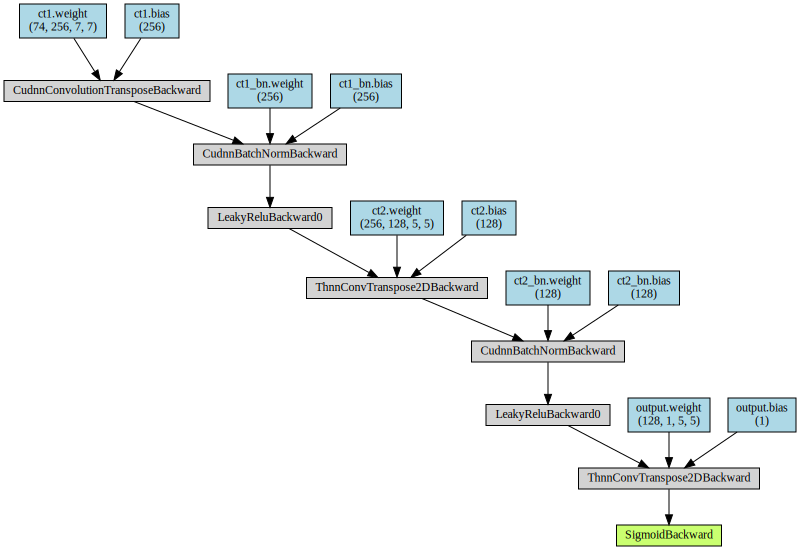

In [10]:
print("Generator Architecture")
viz = CGAN.draw_architecture(net=CGAN.netG, show=False, save=exp_path)
viz

Discriminator Architecture


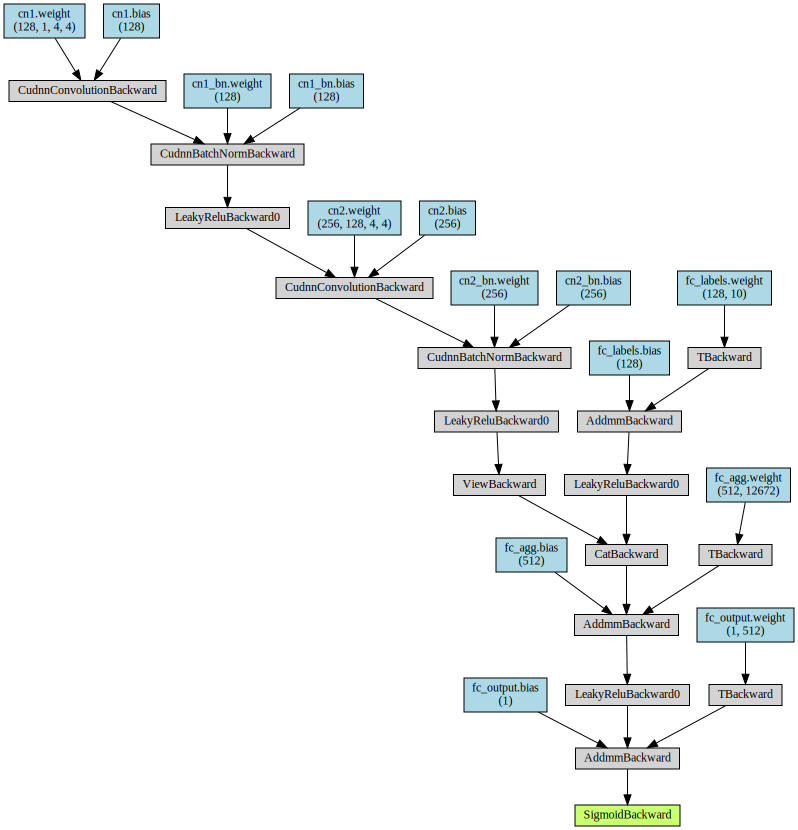

In [11]:
print("Discriminator Architecture")
viz = CGAN.draw_architecture(net=CGAN.netD, show=False, save=exp_path)
viz

Evaluator Architecture


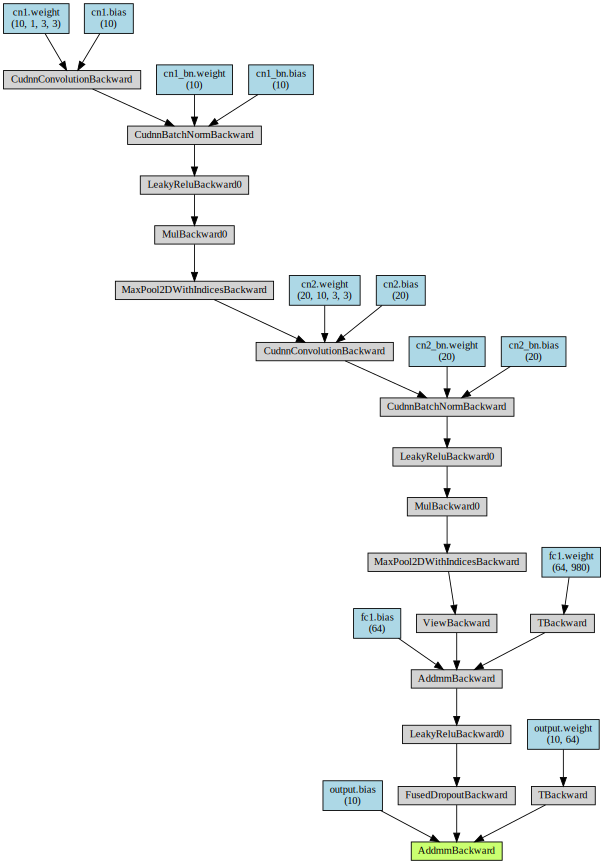

In [12]:
print("Evaluator Architecture")
CGAN.init_evaluator(CGAN.train_gen, CGAN.val_gen)
viz = CGAN.draw_architecture(net=CGAN.netE, show=False, save=exp_path)
viz

### Evaluate performance on real data
Before we train our CGAN, let's train our CGAN evaluator on the training data in order to come up with a benchmark accuracy that we will try to beat with our generator and evaluator combination. We will also return the evaluator network trained here for diagnostics later in the notebook.

In [13]:
try:
    benchmark_acc, real_netE = CGAN.eval_on_real_data(num_epochs=cfg.CGAN_INIT_PARAMS['eval_num_epochs'], es=cfg.CGAN_INIT_PARAMS['early_stopping_patience'])
except RuntimeError:
    benchmark_acc, real_netE = CGAN.eval_on_real_data(num_epochs=cfg.CGAN_INIT_PARAMS['eval_num_epochs'], es=cfg.CGAN_INIT_PARAMS['early_stopping_patience'])
print("Benchmark Accuracy:", benchmark_acc)

Benchmark Accuracy: 0.9759821


###### Results
97.6% Accuracy. That will be pretty hard to beat, and while I don't think we will actually be able to beat this accuracy with our current model, we should be able to get quite close. I challenge you to come up with settings that can beat this score! It may require adjustments to the architecture, but it should be possible with enough tweaking.

## Training the GAN
I've condensed the entire training code into a single line. If you are interested, feel free to check out the source code, but the training regimen is extremely similar to the one implemented for the prior data sets. This one will take significantly longer to run, so feel free to take a break as it runs.

In [14]:
CGAN.train_gan(num_epochs=cfg.NUM_EPOCHS, print_freq=cfg.PRINT_FREQ, eval_freq=cfg.EVAL_FREQ)

Beginning training
Time: 48s
[5/400]	Loss_D: 1.3691	Loss_G: 0.7949	D(x): 0.5284	D(G(z)): 0.4706 / 0.4603
Time: 48s
[10/400]	Loss_D: 1.3514	Loss_G: 0.8274	D(x): 0.5282	D(G(z)): 0.4521 / 0.4487
Time: 47s
[15/400]	Loss_D: 1.3334	Loss_G: 0.8573	D(x): 0.5460	D(G(z)): 0.4484 / 0.4380
Time: 47s
[20/400]	Loss_D: 1.3556	Loss_G: 0.8095	D(x): 0.5333	D(G(z)): 0.4624 / 0.4560
Time: 47s
[25/400]	Loss_D: 1.3732	Loss_G: 0.7688	D(x): 0.5214	D(G(z)): 0.4770 / 0.4707
Time: 47s
[30/400]	Loss_D: 1.3846	Loss_G: 0.7275	D(x): 0.5094	D(G(z)): 0.4915 / 0.4874
Time: 47s
[35/400]	Loss_D: 1.3871	Loss_G: 0.7275	D(x): 0.4980	D(G(z)): 0.4872 / 0.4861
Time: 47s
[40/400]	Loss_D: 1.3874	Loss_G: 0.6979	D(x): 0.5065	D(G(z)): 0.4990 / 0.5002
Time: 47s
[45/400]	Loss_D: 1.3868	Loss_G: 0.6962	D(x): 0.5072	D(G(z)): 0.5018 / 0.5000
Time: 47s
[50/400]	Loss_D: 1.3858	Loss_G: 0.7066	D(x): 0.5007	D(G(z)): 0.4966 / 0.4948
Epoch: 50	Evaluator Score: 0.9171
Time: 543s
[55/400]	Loss_D: 1.3877	Loss_G: 0.6983	D(x): 0.5015	D(G(z)): 0.4985

###### Results
Much better! While we weren't able to actually defeat the model trained on real data, we were able to get quite close! I think this is an impressive accomplishment, but I challenge you to play around with the settings and see if you can improve on these results!

Fortunately, when it comes to generating images, there are additional ways to measure performance than just training a model on generated data. We can visually inspect the images! Let's see if either of us can distinguish fake images from real ones.

## Visualize Results
I've implemented several methods to analyze the training diagnostics as well as analyzing our model's output. Let's take a look!

#### Display final grid of generated images
Here is a grid of images generated by our netG when it was first initialized:

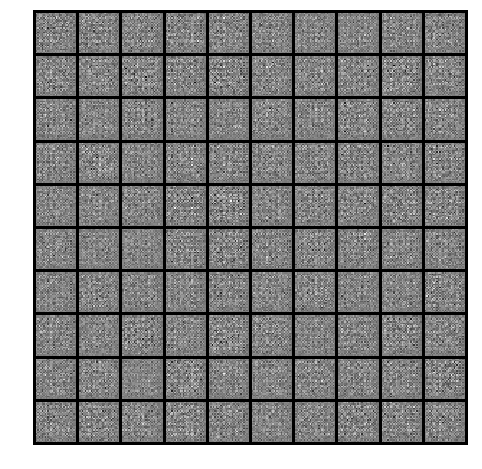

In [15]:
CGAN.show_grid(0)

Pretty noisy, huh? Here the same grid after it finished training:

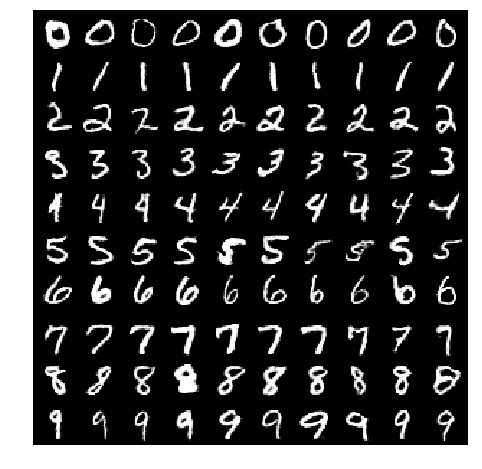

In [16]:
CGAN.show_grid(-1)

Much better! These look pretty realistic to me. Can you spot any telltale signs that it is a fake? For comparison, here is the same style of grid, but this time it is composed of real images:

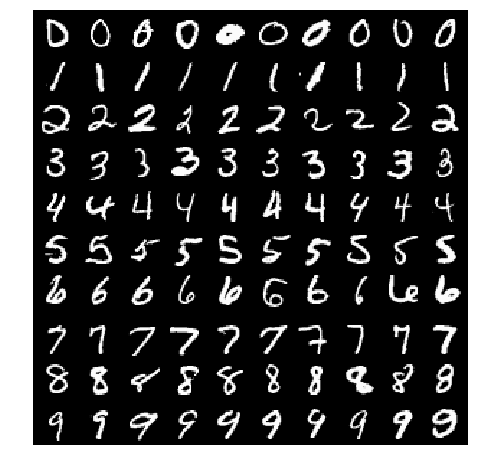

In [17]:
show_real_grid(x_train=x_train, y_train=np.argmax(y_train, 1), nc=10, num_channels=1, grid_rows=10, x_dim=(28, 28))

#### Generate sample images
The show_img method allows us to generate images conditioned on the label (sort of the point of training a CGAN). Feel free to run it a few times, playing with the input (the value of the image to be generated):

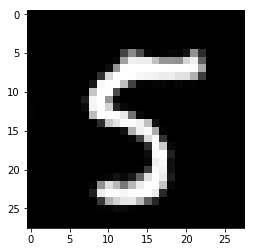

In [18]:
CGAN.show_img(5)

## All other diagnostics
As I wrote up more and more diagnostic tests, it made sense to write a single method to run all of the model training and troubleshooting diagnostics. Here is that method, and it will print out the desired outputs as well as save them to a folder for future analysis:

`CGAN.run_all_diagnostics(real_netE=real_netE, benchmark_acc=benchmark_acc, save=exp_path, show=True)`

This one will take a minute or two to run!

Alternatively, we can step through each method one, so that we can discuss each output individually:

### Evaluation Progress Plot

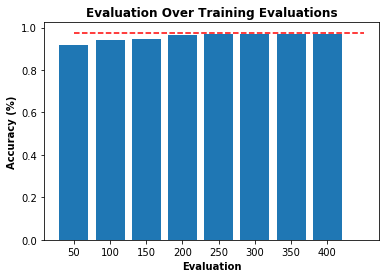

<Figure size 432x288 with 0 Axes>

In [19]:
CGAN.plot_progress(benchmark_acc=benchmark_acc, show=True, save=exp_path)

This plot visualizes the progression of the evaluator trained on generated data at 40 epoch intervals, as compared against a benchmark of a model trained on real data (dashed red line). While we didn't quite achieve the benchmark accuracy, we came quite close!

### GIF of fixed noise progress

In [20]:
# from IPython.display import Image
# CGAN.build_gif(path=exp_path)
# with open(exp_path + '/generation_animation.gif', 'rb') as file:
#     display(Image(file.read()))

This one is my personal favorite. Above is a GIF of many images slapped together demonstrating the CGAN's progress on a single, fixed noise vector across epochs. I think it's particularly interesting to focus on a few images at a time in order to see how they change over time (especially compared to the progress plot shown above).

### Training diagnostic plots

/home/aj/.local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


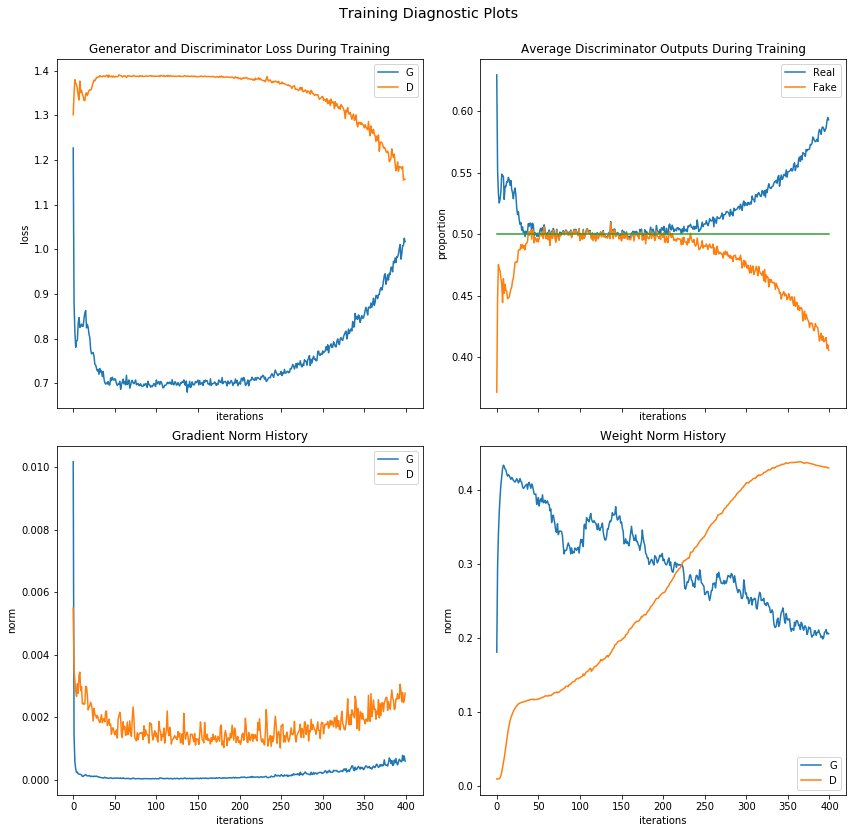

In [21]:
CGAN.plot_training_plots(show=True, save=exp_path)

/home/aj/.local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


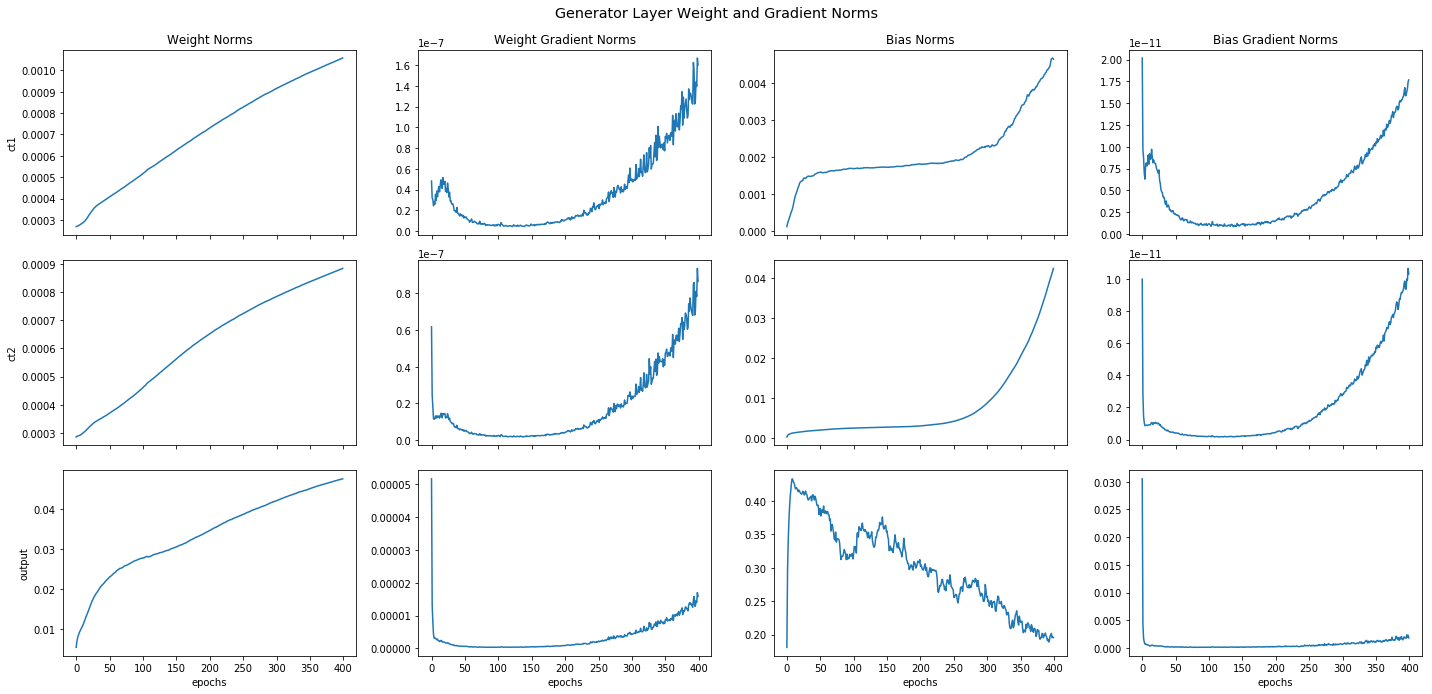

In [22]:
CGAN.netG.plot_layer_scatters(show=True, save=exp_path)

/home/aj/.local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


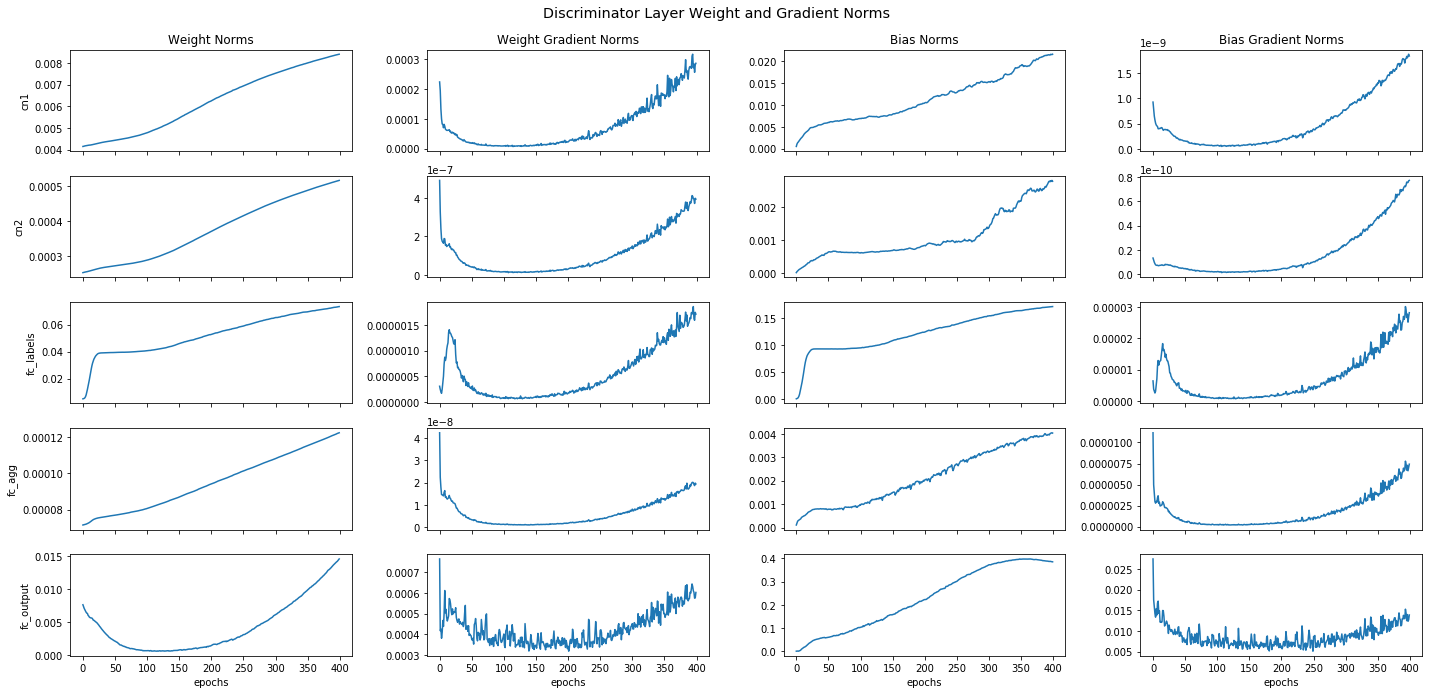

In [23]:
CGAN.netD.plot_layer_scatters(show=True, save=exp_path)

You might be familiar with these plots from the previous experiments. Right now we are looking at diagnostic plots of the training process for the generator and discriminator subnets. At first, it might look strange that the plots do not look to be converging. This is a result of annealing the label noise all the way to zero. Perhaps the model should have been trained for longer, or we should have annealed to a value greater than zero, as it looks like it might be causing some instability in training.

### Layer histograms

/home/aj/.local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


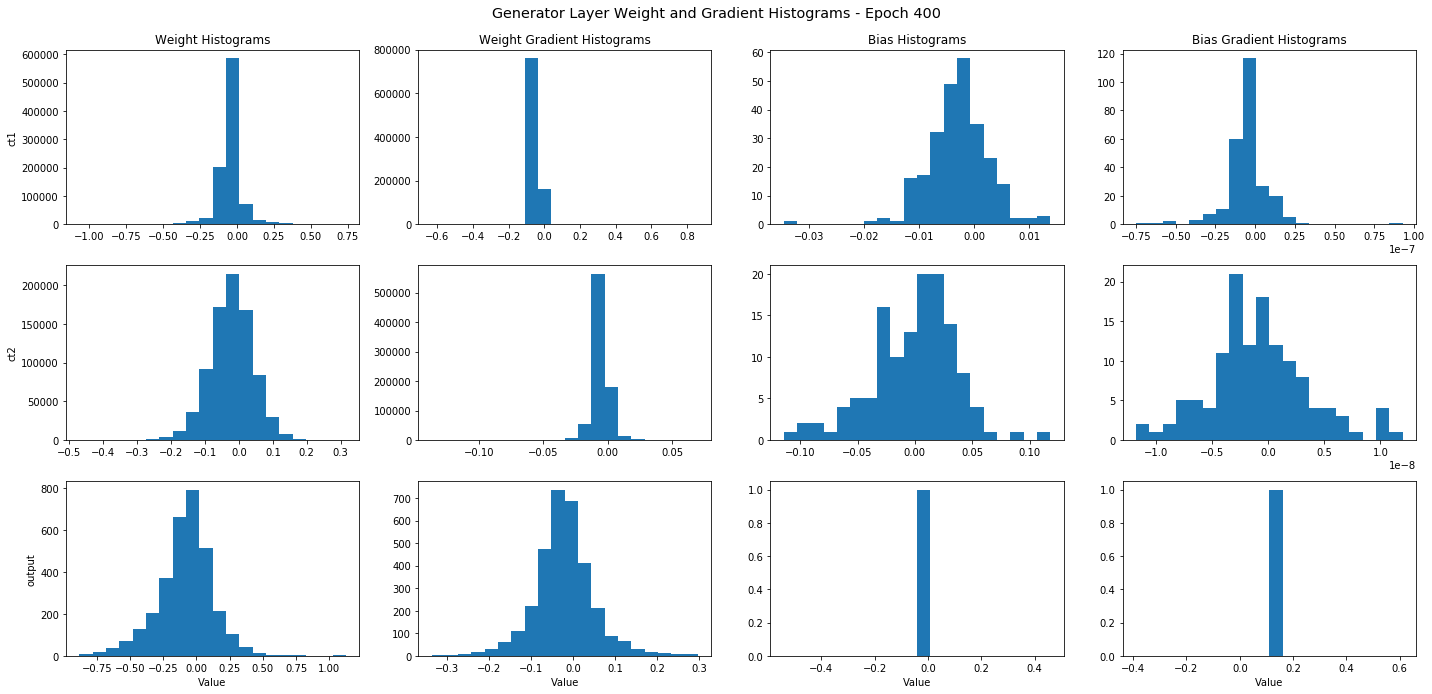

In [24]:
CGAN.netG.plot_layer_hists(show=True, save=exp_path)

/home/aj/.local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


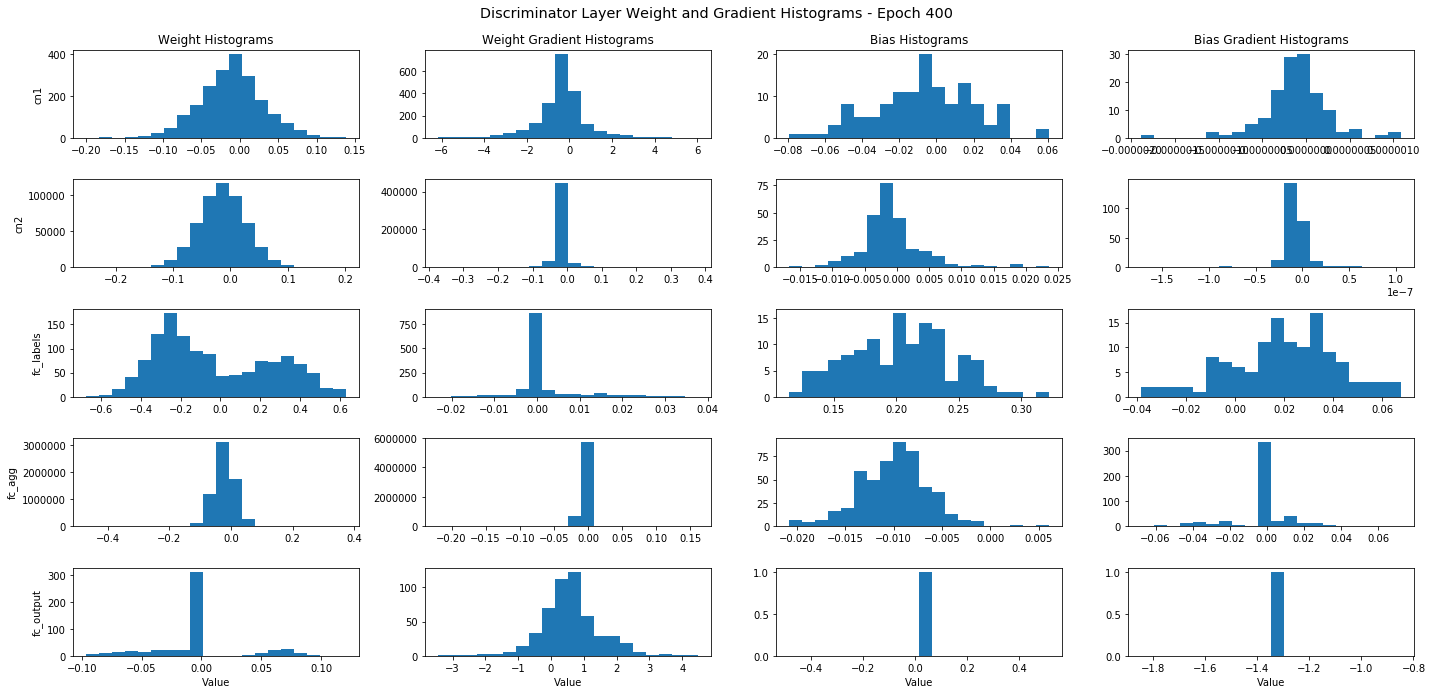

In [25]:
CGAN.netD.plot_layer_hists(show=True, save=exp_path)

Here we can see plots of the distributions of weights and gradients for our subnetworks. This is another good diagnostic to make sure nothing out of the ordinary is occurring, and can give insight into different parameters or architectures to try out in future experiments. We have actually saved one of these histograms for each epoch of training, so we can put together a GIF like above! Let's check it out:

Note: These histogram gifs are fairly large and your browser may experience issues getting them to run live. I recommend building them and displaying them on your own outside of the notebook!

In [26]:
# CGAN.netG.build_hist_gif(path=exp_path)
# with open(exp_path + '/Generator_histogram_generation_animation.gif', 'rb') as file:
#     display(Image(file.read()))

In [27]:
# CGAN.netD.build_hist_gif(path=exp_path)
# with open(exp_path + '/Discriminator_histogram_generation_animation.gif', 'rb') as file:
#     display(Image(file.read()))

### Troubleshooting the discriminator
Now let's take a look at some examples of how our discriminator is working.

/home/aj/.local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


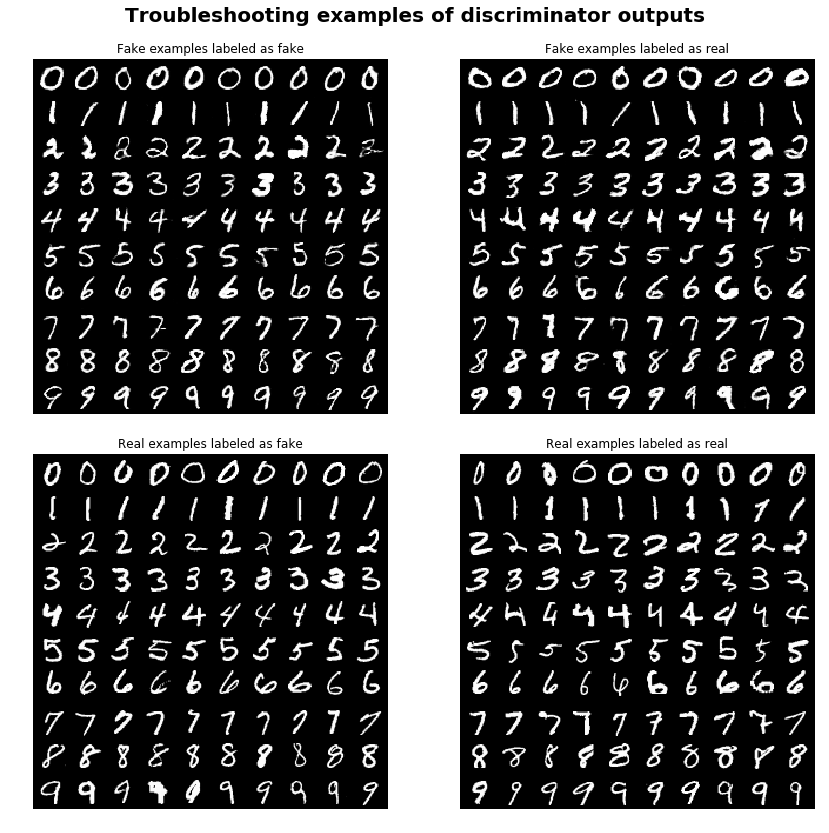

In [28]:
CGAN.troubleshoot_discriminator(show=True, save=exp_path)

This is a helpful test for picking up on how the discriminator is behaving. In the top row, we can compare generated examples and whether the discriminator labeled them as real or fake. For example, notice the third-to-last 7 in the top-left plot. I would probably label that image as fake too. However, for many of the other images, it is difficult to tell why the discriminator thought to label them as fake. For comparison, real images labeled as both real and fake are included below as well.

### Troubleshooting the evaluator
We can do the same thing with the evaluator.

/home/aj/.local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


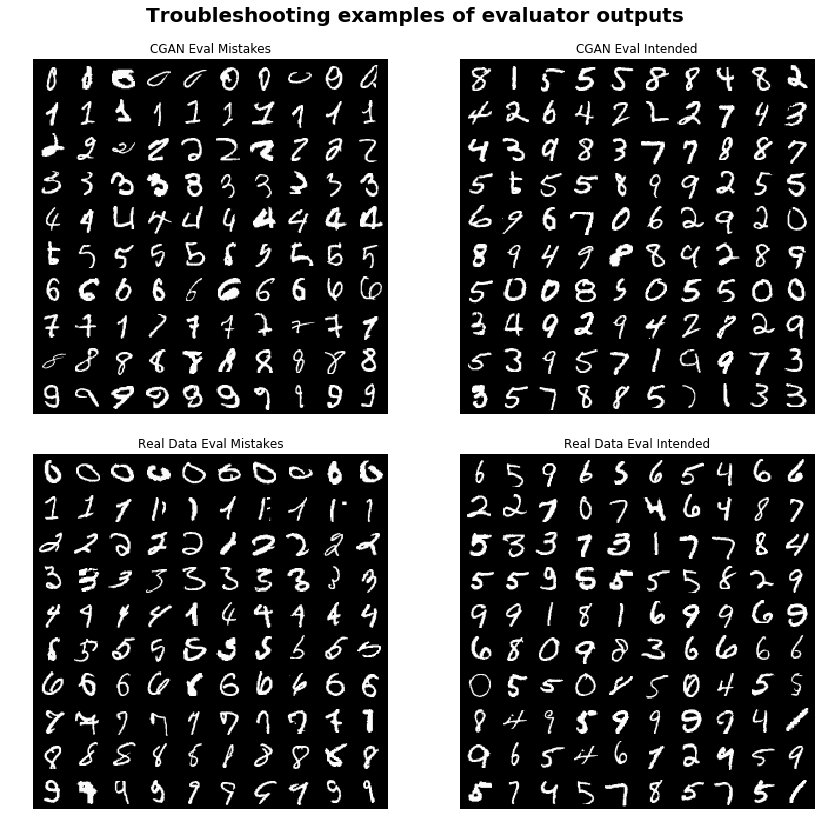

In [29]:
CGAN.troubleshoot_evaluator(real_netE=real_netE, show=True, save=exp_path)

Checking out examples where a supervised model fails is always fascinating to me. You get to put yourself in your model's shoes and try to determine why it might have made a mistake. The left column of plots show examples where each respective model failed, and the right column plots is simply there to show which class the evaluator thought the corresponding image in the left column was supposed to be. For example, the very first image in the top left plot is clearly a 0, but the CGAN evaluator thought it was a 9.

### Gradient Class Activation (Heat)Map (Grad CAM)
There is an interesting paper/technique that came out awhile back that uses gradient actvations of the last convolutional layer in a network to dig into and visualize how a network may be making its decisions. Let's take a look at implementing this technique for our discriminator and evaluator networks.

We can use the draw_cam method of the CGAN class to apply grad CAM to an image that satisfies particular requirements. For example, let's say we wanted to check out an example that was:
1. Generated by our generator
2. Classified by our discriminator
3. Label of "3"
4. Mistakenly classified as real

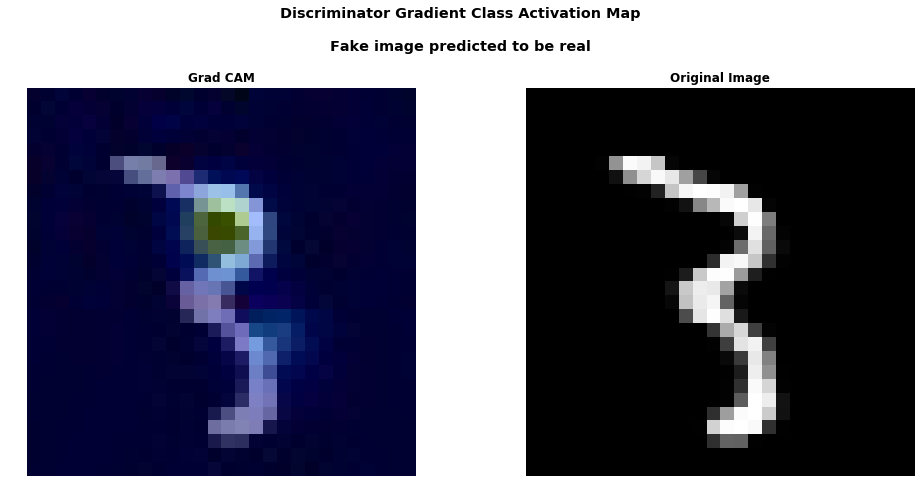

In [30]:
CGAN.draw_cam(gen=CGAN.netG, net=CGAN.netD, label=3, mistake=True, path=exp_path + "/gradcam1.jpg", show=True)

How about another 3 that was accurately predicted to be fake?

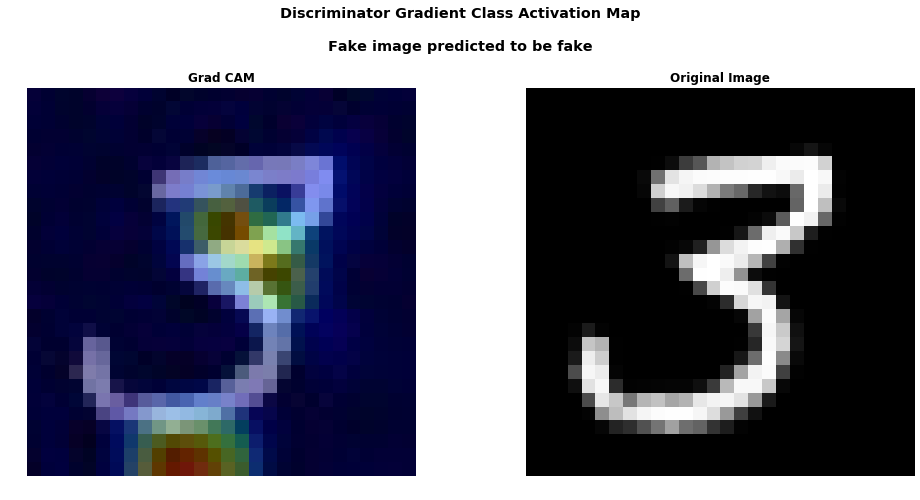

In [31]:
CGAN.draw_cam(gen=CGAN.netG, net=CGAN.netD, label=3, mistake=False, path=exp_path + "/gradcam2.jpg", show=True)

For the sake of completeness, let's check out a pair of images from the original training data that were correctly and incorrectly classified by the discriminator:

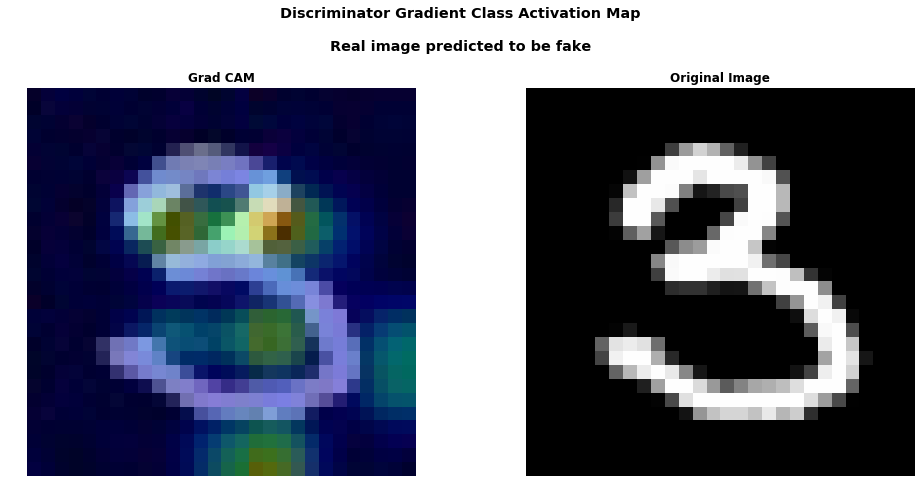

In [32]:
CGAN.draw_cam(gen=CGAN.train_gen, net=CGAN.netD, label=3, mistake=True, path=exp_path + "/gradcam3.jpg", show=True)

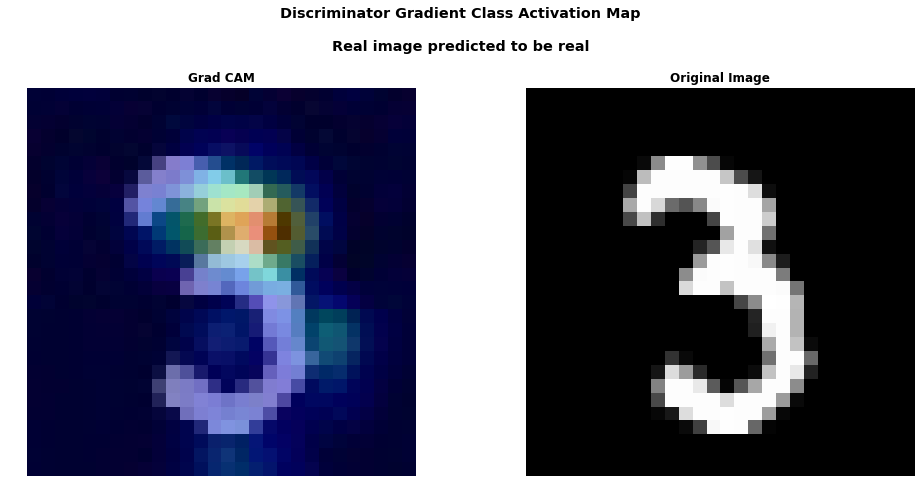

In [33]:
CGAN.draw_cam(gen=CGAN.train_gen, net=CGAN.netD, label=3, mistake=False, path=exp_path + "/gradcam4.jpg", show=True)

I think it's really interesting how the discriminator is consistently focusing on the same two areas in the image of the 3 in order to determine whether it is real or fake. Perhaps the 3's that appear to be tilted to the left are more likely classified as fake versus ones that are not so tilted? Try playing around with different settings (including using the evaluator) and see what other insights you can glean from this experiment!

### Evaluator Classification Statistics
Let's dig a little deeper into how our evaluator is performing based on whether it was trained on real or fake data.


CGAN Evaluator Network Classification Stats:



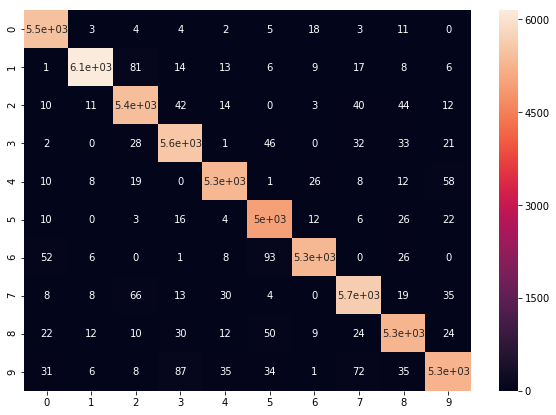

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5522
           1       0.99      0.98      0.98      6302
           2       0.96      0.97      0.96      5592
           3       0.96      0.97      0.97      5713
           4       0.98      0.97      0.98      5459
           5       0.95      0.98      0.97      5050
           6       0.99      0.97      0.98      5501
           7       0.97      0.97      0.97      5834
           8       0.96      0.96      0.96      5460
           9       0.97      0.94      0.96      5567

    accuracy                           0.97     56000
   macro avg       0.97      0.97      0.97     56000
weighted avg       0.97      0.97      0.97     56000


Real Data Evaluator Network Classification Stats:



<Figure size 432x288 with 0 Axes>

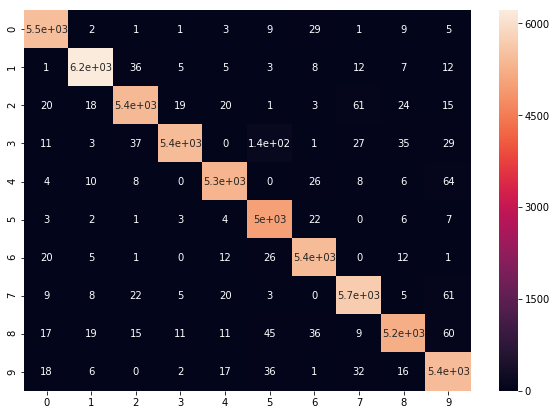

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      5522
           1       0.99      0.99      0.99      6302
           2       0.98      0.97      0.97      5592
           3       0.99      0.95      0.97      5713
           4       0.98      0.98      0.98      5459
           5       0.95      0.99      0.97      5050
           6       0.98      0.99      0.98      5501
           7       0.97      0.98      0.98      5834
           8       0.98      0.96      0.97      5460
           9       0.96      0.98      0.97      5567

    accuracy                           0.98     56000
   macro avg       0.98      0.98      0.98     56000
weighted avg       0.98      0.98      0.98     56000



<Figure size 432x288 with 0 Axes>

In [34]:
print("\nCGAN Evaluator Network Classification Stats:\n")

cm_gen, cr_gen = CGAN.netE.classification_stats(title='CGAN', show=True, save=exp_path)

print(cr_gen)

print("\nReal Data Evaluator Network Classification Stats:\n")

cm_real, cr_real = real_netE.classification_stats(title='Real', show=True, save=exp_path)

print(cr_real)

Now we have a chance to look at the classification statistics by class label for each of the evaluators to get a statistical look at which labels our model is good at producing. It looks like the real data evaluator is performing better fairly consistently across the board, and I don't see any clear discrepancies in performance.

## Experimenting with Data Augmentation
The final stage of this experiment will be to play around with data augmentation. The goal will be to study how our CGAN approach compares to traditional data augmentation techniques. We will do this by training an evaluator network on the original training data augmented with traditional techniques, and comparing performance on the test set to an evaluator trained on the original training data augmented with our generator. Let's see how we do!

In [35]:
print("Adding 10,000 images to our training set through traditional image augmentation")
augment(train_dataset, 10000)
augmented_training_generator = data.DataLoader(train_dataset, **cfg.TRAINING_PARAMS)

Adding 10,000 images to our training set through traditional image augmentation


In [36]:
trad_acc, _ = CGAN.eval_on_real_data(train_gen=augmented_training_generator, 
                                     val_gen=CGAN.val_gen,
                                     test_gen=CGAN.test_gen,
                                     num_epochs=cfg.CGAN_INIT_PARAMS['eval_num_epochs'], 
                                     es=cfg.CGAN_INIT_PARAMS['early_stopping_patience'])
print("Score through traditional augmentation:", trad_acc)

Score through traditional augmentation: 0.98


In [42]:
print("Adding 10,000 images to our training set through CGAN image augmentation")
generator_augmented_training_set = GeneratedImageDataset(CGAN.netG, CGAN.fake_data_set_size, CGAN.nz, CGAN.nc, CGAN.num_channels, CGAN.fake_bs, CGAN.ohe, CGAN.device, CGAN.x_dim)
augment(generator_augmented_training_set, 10000)
generator_augmented_training_generator = data.DataLoader(generator_augmented_training_set, **cfg.TRAINING_PARAMS)

Adding 10,000 images to our training set through CGAN image augmentation


In [43]:
CGAN_acc, _ = CGAN.eval_on_real_data(train_gen=generator_augmented_training_generator, 
                                     val_gen=CGAN.val_gen,
                                     test_gen=CGAN.test_gen,
                                     num_epochs=cfg.CGAN_INIT_PARAMS['eval_num_epochs'], 
                                     es=cfg.CGAN_INIT_PARAMS['early_stopping_patience'])
print("Score through CGAN augmentation:", CGAN_acc)

Score through CGAN augmentation: 0.96489286


Unfortunately, we were unable to improve our evaluation score through generation (and were able to improve it with traditional augmentation!). I'm sure with enough tuning and playing around, you could design a generator that could improve your performance (perhaps by optimizing this metric instead). I encourage you to try it out!

## Conclusion
Together we successfully trained a CGAN (technically a cDCGAN I suppose) to generate realistic looking images of the MNIST handwritten image data set. While we we weren't able to generate images good enough to train a model on to outperform the original data like we were able to with the previous several data sets, I think you'd be hard pressed to find a human able to distinguish the generated images from the real ones.

We also analyzed the training process in detail, dug deep into the various subnetwork's architectures, their performance, and their various outputs. We used grad CAM to try and visualize how some of the subnetworks were working, and ended with some experimentation with data augmentation using the GAN as well as more traditional techniques.

Thank you for reading this all the way through, and I hope you learned something (and had fun doing so). Next stop, FashionMNIST!